<a href="https://colab.research.google.com/github/Yung-Huei/Python/blob/main/HW1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1

#!git clone https://github.com/RunpengDai/ICSA_DLcourse.git
#!git clone https://github.com/RunpengDai/BIOS740.git

Mounted at /content/drive
/content/drive/MyDrive/BIOS740/Homework/Homework 1


In [3]:
!pip install pytorch_lightning
import glob #讀取檔案路徑，例如找到所有.CSV檔
import pandas as pd #讀取表格資料（如 CSV）與 DataFrame 操作
import numpy as np #提供高效的陣列處理
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader #自訂數據集的類別/用來分批（batch）讀取資料，支援打亂、並行處理等功能
from sklearn.model_selection import train_test_split #用來將資料集依比例分成訓練集與測試集
import pytorch_lightning as pl #可以減少訓練時的 boilerplate code and 管理訓練流程、自動處理 GPU/TPU、記錄等。
from torchvision import models,transforms #圖像處理: 預訓練模型（如 ResNet、VGG）/資料預處理（如 resize、normalize、data augmentation）
import torchvision.transforms.functional as TF #例如隨機旋轉、裁切、水平翻轉
from pytorch_lightning.callbacks.early_stopping import EarlyStopping #提早停止訓練的回呼函數（Callback），如果驗證集的表現停止進步，就會自動停止訓練以避免 overfitting。
from pytorch_lightning.loggers import CSVLogger #將訓練過程的紀錄（如損失、準確率）寫入 .csv 檔，方便後續分析。
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 54.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

**Predicting Alzheimer's Disease Status Using Hippocampal Data**

阿茲海默症（Alzheimer's Disease, AD）是一種神經退化性疾病，其特徵為認知功能逐漸衰退。海馬迴的萎縮（hippocampus atrophy）是阿茲海默症早期的生物標記之一，而海馬迴是對記憶形成非常關鍵的大腦區域。

*   Source: ADNI資料庫
*   Sample Size: 369 位受試者的左側與右側海馬迴矩陣 (extracted from MRI scans)


    1.   Left Hippocampus Matrix: Dimensions 7x150x100 per subject.
    2.   Right Hippocampus Matrix: Dimensions 7x150x100 per subject.
    3.   Feature Description: radial distance from the medial model; the (log)determinant and two eigenvalues of the Jacobian matrix from the surface tensor-basedmorphometry (TBM) model (referred to as the determinant, eigenvalue1, and eigenvalue2); and three features from the multivariate surface TBM (mTBM) model (referred to as the mTBM1, mTBM2, and mTBM3.
    4.   AD Status Labels: A separate CSV file indicating the AD status (AD or Control) for each subject.


*   Format: 壓縮的 CSV 檔案
*   Method: CNN



In [4]:
!ls
# # 複製 zip 檔案到 Colab 當前目錄
#!cp "/content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data/LeftCSV.zip"
#!cp "/content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data/RightCSV.zip"
#!ls

 adni_subset.csv   cnn-sol.ipynb    requirements.txt
'Chap3 HW.docx'    HW1_data	    RightCSV_subset
 cnn.ipynb	   LeftCSV_subset   selected_samples_subset.txt


In [5]:
# Data Loading:
# Decompress and load the CSV files containing the hippocampal matrices.
# https://drive.google.com/drive/folders/1X1HPde-5snvjZhUyYKu5BHtqoJyCLrYb?usp=share_link

# 解壓縮
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data
!unzip -o RightCSV.zip -d "/content/drive/MyDrive/BIOS740/Homework/Homework 1/"
!unzip -o LeftCSV.zip -d "/content/drive/MyDrive/BIOS740/Homework/Homework 1/"
!ls
print("=========")
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1/
subject_ids = np.loadtxt("selected_samples_subset.txt", dtype=str)
left_hippo_dir = "LeftCSV_subset/"
left_hippo_files = glob.glob(left_hippo_dir+"*") #檔案路徑
right_hippo_dir = "RightCSV_subset/"
right_hippo_files = glob.glob(right_hippo_dir+"*")
labels = pd.read_csv("adni_subset.csv",names=['ID','AD'])
print(subject_ids[:5])
print(left_hippo_files[:3])

#Describe the dimensions and structure of the data.


/content/drive/.shortcut-targets-by-id/1X1HPde-5snvjZhUyYKu5BHtqoJyCLrYb/HW1_data
Archive:  RightCSV.zip
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0295__2011-06-02__S110477.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0413__2011-06-16__S111989.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0685__2010-07-15__S89145.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_1261__2011-03-14__S101641.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_1280__2011-05-04__S108096.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_4213__2011-09-02__S121165.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_4225__2011-09-21__S122885.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightC

In [6]:
class HippocampusDataset(Dataset): #繼承自 torch.utils.data.Dataset，用來與 PyTorch 的 DataLoader 搭配使用。
    def __init__(self, left_hippo_files, right_hippo_files, labels=None): #建構函式
        self.left_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in left_hippo_files] #讀取檔案/ .values：轉成 NumPy array
        self.right_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in right_hippo_files]
        self.labels = labels['AD'] if labels is not None else None

    def __len__(self): #傳回資料筆數
        return len(self.left_hippo)

    def __getitem__(self, idx): #回傳第 idx 筆資料（模型訓練時會呼叫）
        left = self.left_hippo[idx].astype(np.float32)  # shape: (15000, 7) #GPU 運算（如 CUDA）對 float32 支援更好、更快
        right = self.right_hippo[idx].astype(np.float32) # shape: (15000, 7) # 是 NumPy 的陣列（np.ndarray）非tensor

        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################

        # Step 1: Concatenate
        sample = np.concatenate((left, right), axis=1)  # (15000, 14) # axis=0 垂直拼接 反之水平拼接

        # Step 2: Transpose
        sample = sample.T  # (14, 15000)

        # Step 3: Reshape each feature to (14, 150, 100)
        sample = sample.reshape(14, 150, 100)
        # sample = sample[[0, 7], :, :]

        # Step 4a: Convert to PyTorch tensor
        sample = torch.tensor(sample, dtype=torch.float32)  # (14, 150, 100)

        # Step 4b: Normalize each feature channel
        mean = sample.mean(dim=(1, 2), keepdim=True)  # shape: (14, 1, 1)
        std = sample.std(dim=(1, 2), keepdim=True)    # shape: (14, 1, 1)
        sample = (sample - mean) / (std + 1e-8)       # add epsilon to avoid /0

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return sample, label
        else:
            return sample


The training set contain 236 samples.
Each sample has shape torch.Size([14, 150, 100]).


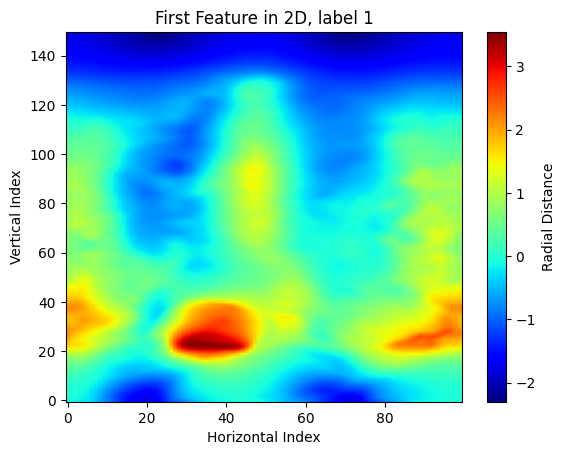

In [9]:
#subject_ids + 左右腦影像路徑
data_df = pd.DataFrame({
    'ID': subject_ids,
    'LeftFile': left_hippo_files,
    'RightFile': right_hippo_files
})

# Merge data and labels on SubjectID
merged_df = pd.merge(data_df, labels, on='ID', how='inner')  # on: 指定要根據哪一個欄位進行合併。
                                  # how: "inner" 只保留「兩邊都有」的 ID（交集） Keep only subjects with labels
# Now extract the filtered lists
filtered_left_files = merged_df['LeftFile'].tolist() #左右腦路徑清單
filtered_right_files = merged_df['RightFile'].tolist()

unique_labels = sorted(set(labels['AD'])) #set 會取出不重複的標籤（集合）
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #創一個字典
labels['AD'] = [label_to_index[label] for label in labels['AD']]

# Split into training and validation sets
train_left, test_left, train_right, test_right, train_labels, test_labels = train_test_split(
    filtered_left_files, filtered_right_files, labels, test_size=0.2, random_state=42
)
train_left, val_left, train_right, val_right, train_labels, val_labels = train_test_split(
    train_left, train_right, train_labels, test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
train_dataset = HippocampusDataset(train_left, train_right, train_labels)
val_dataset = HippocampusDataset(val_left, val_right, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

test_dataset = HippocampusDataset(test_left, test_right, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

# visualize some samples
print(f"The training set contain {len(train_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.")

example_rd_tensor = train_dataset[0][0][0]  #train_dataset[0] == (sample_tensor, label)
                        #train_dataset[0][0] == sample_tensor (14*150*100)
                        #train_dataset[0][0][0]-->(150, 100)
# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() #把 tensor 搬回 CPU	轉成 NumPy 陣列（方便視覺化、處理）

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto')
plt.colorbar(label="Radial Distance")
plt.title(f"First Feature in 2D, label {train_dataset[0][1]}")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.show()

## Naive CNN model


### First we create a trainer
